In [1]:
# The basics
import numpy as np
import pandas as pd

# Import Sklearn model libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


# Import Utility libraries
import shap
from collections import Counter
import pickle
from tqdm import tqdm_notebook
import warnings
import ipyparallel as ipp
import time
import torch as torch
from torch import nn
import torch.optim as optim
from termcolor import colored
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
# Pre-run necessities
warnings.filterwarnings('ignore')
rnds = [60, 452, 774, 802, 961, 626, 726, 211, 375, 448, 883, 684, 724, 333, 64, 646, 116, 714, 483, 73, 562, 703, 276, 394, 190, 675, 314, 604, 297, 266, 456, 845, 822, 529, 420, 605, 935, 733, 167, 603, 401, 948, 241, 734, 550, 65, 429, 470, 633, 627, 223, 713, 958, 40, 200, 641, 357, 778, 781, 498, 202, 349, 983, 125, 548, 331, 206, 556, 356, 805, 246, 626, 358, 393, 307, 792, 777, 169, 595, 279, 719, 902, 124, 197, 983, 499, 368, 864, 896, 887, 879, 224, 220, 926, 565, 173, 919, 3, 908, 941]

In [2]:
def read_file(run,dataset_name,influence_type,n_est):

    parent_dir = '/home/amanmoha/influence_attack/results/actual/estimator_analysis'
    directory = dataset_name+'/'+influence_type+'/'+'run'+run+'/'+'n_est-'+str(n_est)
    path = os.path.join(parent_dir,directory)

    with open(path+'/data.txt','rb') as f:
        data = pickle.load(f)
    f.close()
    
    with open(path+'/metrics.txt','rb') as f:
            metrics = pickle.load(f)
    f.close()
        
    return data, metrics

In [3]:
class deep_attack():
    
    def __init__(self,lr,weight_decay,test_size,n_epochs,rs):
        self.lr = lr
        self.weight_decay = weight_decay
        self.test_size = test_size
        self.n_epochs = n_epochs
        
        self.train_accuracy = []
        self.train_precision = []
        self.train_recall = []
        self.train_f1 = []
        self.target_accuracy = []
        self.target_recall = []
        self.target_precision = []
        self.target_f1 = []
        
        self.loss_train = np.zeros(n_epochs)
        self.acc_train = np.zeros(n_epochs)
        self.loss_test = np.zeros(n_epochs)
        self.acc_test = np.zeros(n_epochs)
        self.rs = rs
        
    def fit(self,x,y):
        self.n_states = x.shape[0]
        self.n_feat = x.shape[2]
        self.n_hidden = self.n_feat*2

        for i in range(self.n_states):

            x_train, x_test, y_train, y_test = train_test_split(x[i],y[i],test_size=0.2,random_state=self.rs)
            x_train_torch,x_test_torch,y_train_torch,y_test_torch = torch.Tensor(x_train),torch.Tensor(x_test),torch.Tensor(y_train),torch.Tensor(y_test)

            # Model Definition
            self.model = nn.Sequential(nn.Linear(self.n_feat,self.n_hidden),
                                  nn.ReLU(),
                                  nn.Linear(self.n_hidden,2))
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(self.model.parameters(),lr=self.lr,weight_decay=self.weight_decay)
            
            # Runs
            for epoch in range(self.n_epochs):

                # Initialize
                optimizer.zero_grad()
                
                # Train data through model
                out_train = self.model(x_train_torch)
                pred_prob_train = nn.functional.softmax(out_train)
                pred_train = torch.argmax(pred_prob_train,axis=1)
                y_train_torch = y_train_torch.long()
                loss_train = criterion(pred_prob_train,y_train_torch)
                
                # Train data through model
                out_test = self.model(x_test_torch)
                pred_prob_test = nn.functional.softmax(out_test)
                pred_test = torch.argmax(pred_prob_test,axis=1)
                y_test_torch = y_test_torch.long()
                loss_test = criterion(pred_prob_test,y_test_torch)
                
                # Learning
                loss_train.backward()
                optimizer.step()

                # Record metrics
                self.loss_train[epoch]+=loss_train
                self.acc_train[epoch]+=accuracy_score(y_train_torch,pred_train)
                self.loss_test[epoch]+=loss_test
                self.acc_test[epoch]+=accuracy_score(y_test_torch,pred_test)
                
            self.train_accuracy.append(accuracy_score(y_train_torch,pred_train))
            self.train_precision.append(precision_score(y_train_torch,pred_train))
            self.train_recall.append(recall_score(y_train_torch,pred_train))
            self.train_f1.append(f1_score(y_train_torch,pred_train))
                
    def predict(self,x,y):
        
        for i in range(self.n_states):
            x_torch,y_torch = torch.Tensor(x[i]),torch.Tensor(y[i])
            output = self.model(x_torch)
            pred_prob = nn.functional.softmax(output)
            pred = torch.argmax(pred_prob,axis=1)

            self.target_accuracy.append(accuracy_score(y_torch,pred))
            self.target_precision.append(precision_score(y_torch,pred))
            self.target_recall.append(recall_score(y_torch,pred))
            self.target_f1.append(f1_score(y_torch,pred))
            
    def get_results(self):
        if len(self.target_accuracy) == 0:
#             return self.loss_train/self.n_states,self.acc_train/self.n_states,self.loss_test/self.n_states,self.acc_test/self.n_states,np.mean(self.train_accuracy),np.mean(self.train_precision),np.mean(self.train_recall),np.mean(self.train_f1)
            return self.loss_train/self.n_states,self.acc_train/self.n_states,self.loss_test/self.n_states,self.acc_test/self.n_states,self.train_accuracy,self.train_precision,self.train_recall,self.train_f1
        else:
#             return self.loss_train/self.n_states,self.acc_train/self.n_states,self.loss_test/self.n_states,self.acc_test/self.n_states,np.mean(self.train_accuracy),np.mean(self.train_precision),np.mean(self.train_recall),np.mean(self.train_f1),np.mean(self.target_accuracy),np.mean(self.target_precision),np.mean(self.target_recall),np.mean(self.target_f1)
            return self.loss_train/self.n_states,self.acc_train/self.n_states,self.loss_test/self.n_states,self.acc_test/self.n_states,self.train_accuracy,self.train_precision,self.train_recall,self.train_f1,self.target_accuracy,self.target_precision,self.target_recall,self.target_f1


########## german_credit-SHAP ##########


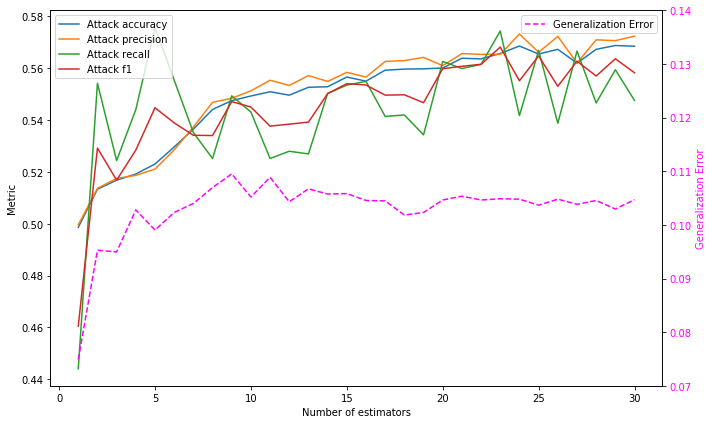

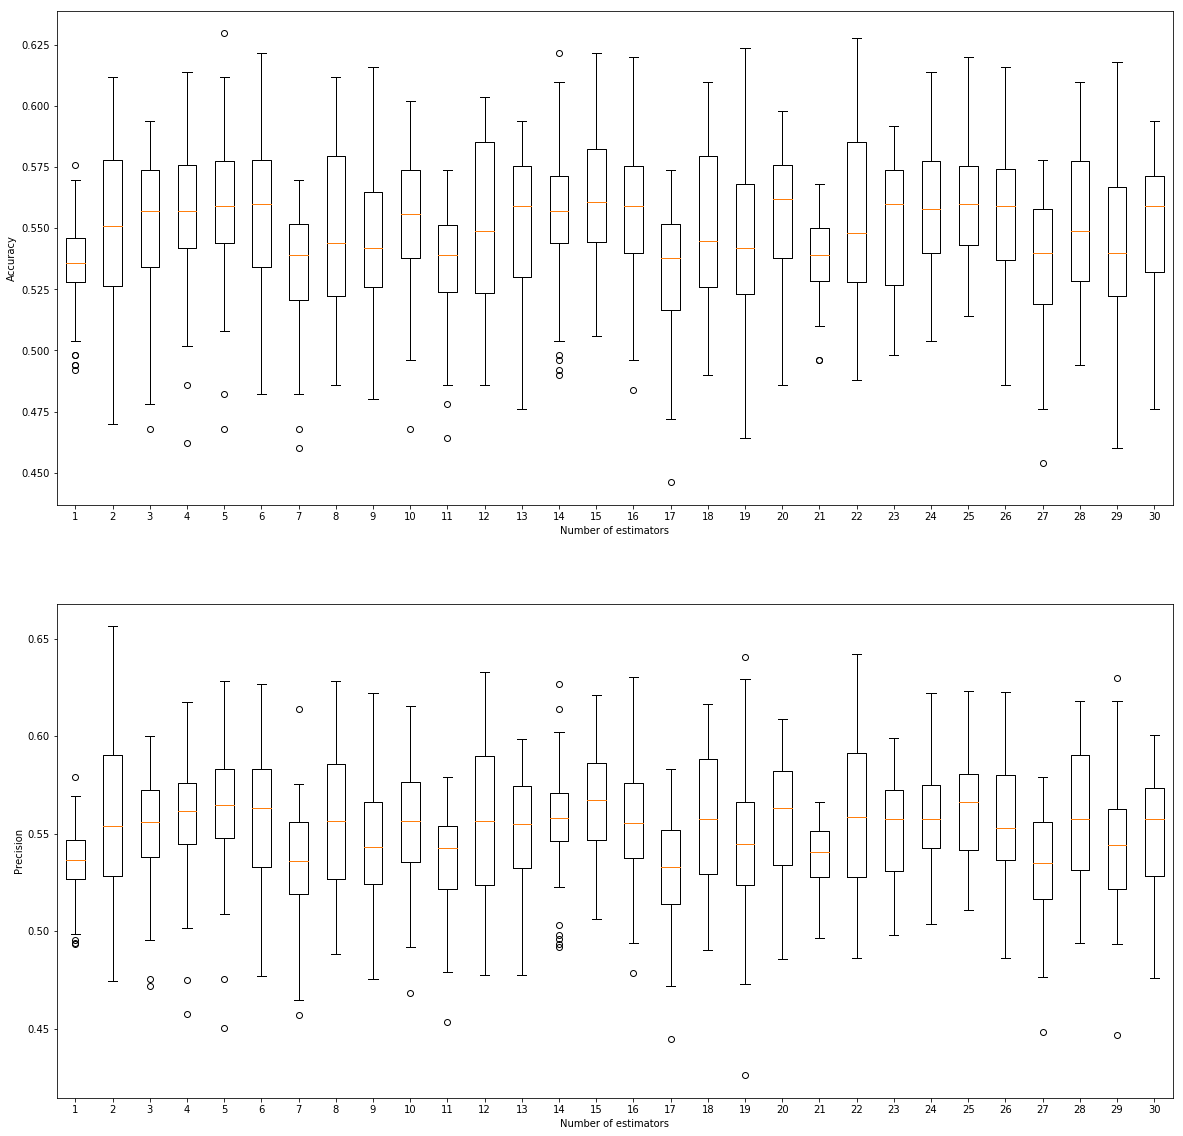

In [8]:
run = '5'
dataset_name = 'german_credit'
influence_type = 'SHAP'
n_ests = 30
params = {'learningRate':0.01,
          'weightDecay':0.00005,
          'testSize':0.2,
          'nEpochs':80,
          'randomState':rnds[0]}
tr_ac_est,te_ac_est,ac_est,ps_est,rs_est,fs_est = [],[],[],[],[],[]

for n_est in tqdm_notebook(range(1,n_ests+1),desc="Estimators:"):
    
    data,metrics = read_file(run,dataset_name,influence_type,n_est)
    tar_val,tar_lab,ref_val,ref_lab,_ = data
    tr_ac,te_ac,_,_,_,_,_,_,_,_ = metrics
    
    attack_obj = deep_attack(lr=params['learningRate'],
                             weight_decay=params['weightDecay'],
                             test_size=params['testSize'],
                             n_epochs=params['nEpochs'],
                             rs=params['randomState'])
    attack_obj.fit(ref_val,ref_lab)
    attack_obj.predict(tar_val,tar_lab)
    _,_,_,_,_,_,_,_,target_accuracy,target_precision,target_recall,target_f1 = attack_obj.get_results()
    
    tr_ac_est.append(tr_ac)
    te_ac_est.append(te_ac)
    ac_est.append(target_accuracy)
    ps_est.append(target_precision)
    rs_est.append(target_recall)
    fs_est.append(target_f1)
    
ac_est = np.array(ac_est)
ps_est = np.array(ps_est)
rs_est = np.array(rs_est)
fs_est = np.array(fs_est)

print("########## {c}-{d} ##########".format(c=dataset_name,d=influence_type))

gen_err = np.subtract(np.mean(tr_ac_est,axis=1),np.mean(te_ac_est,axis=1))
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Metric')
ax.plot(np.arange(1,n_ests+1),np.mean(ac_est,axis=1),label='Attack accuracy')
ax.plot(np.arange(1,n_ests+1),np.mean(ps_est,axis=1),label='Attack precision')
ax.plot(np.arange(1,n_ests+1),np.mean(rs_est,axis=1),label='Attack recall')
ax.plot(np.arange(1,n_ests+1),np.mean(fs_est,axis=1),label='Attack f1')
ax.tick_params(axis='y')

axtwin = ax.twinx()  # instantiate a second axes that shares the same x-axis
axtwin.set_ylabel('Generalization Error',color='magenta')  # we already handled the x-label with ax1
axtwin.plot(np.arange(1,n_ests+1),gen_err,'--',label='Generalization Error',color='magenta')
axtwin.tick_params(axis='y',labelcolor='magenta')
# ax.set_ylim(0.4,0.7)

if dataset_name == 'german_credit':
    axtwin.set_ylim(0.07,0.14)
elif dataset_name == 'bcw':
    axtwin.set_ylim(0.03,0.07)
elif dataset_name == 'pima_diabetes':
    axtwin.set_ylim(0.06,0.11)


ax.legend(loc='upper left')
axtwin.legend(loc='upper right')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# # BOX PLOTS

f,ax=plt.subplots(2,1,figsize=(20,20))
f1=ax[0].boxplot(ac_est.reshape(50,n_ests))
f2=ax[1].boxplot(ps_est.reshape(50,n_ests))
ax[0].set_xlabel('Number of estimators')
ax[0].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of estimators')
ax[1].set_ylabel('Precision')

plt.show()


########## german_credit-SHAP ##########


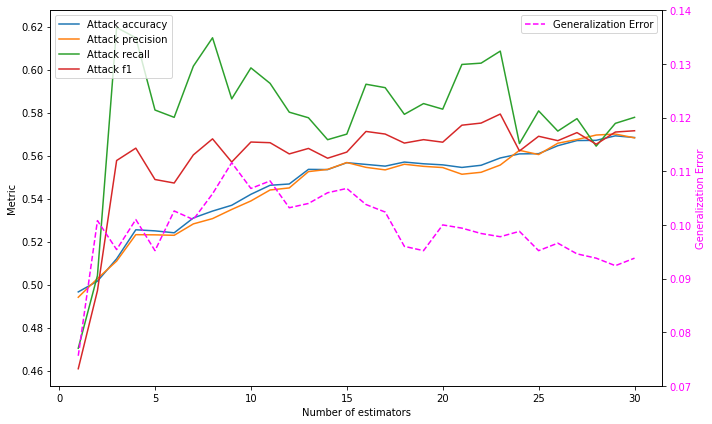

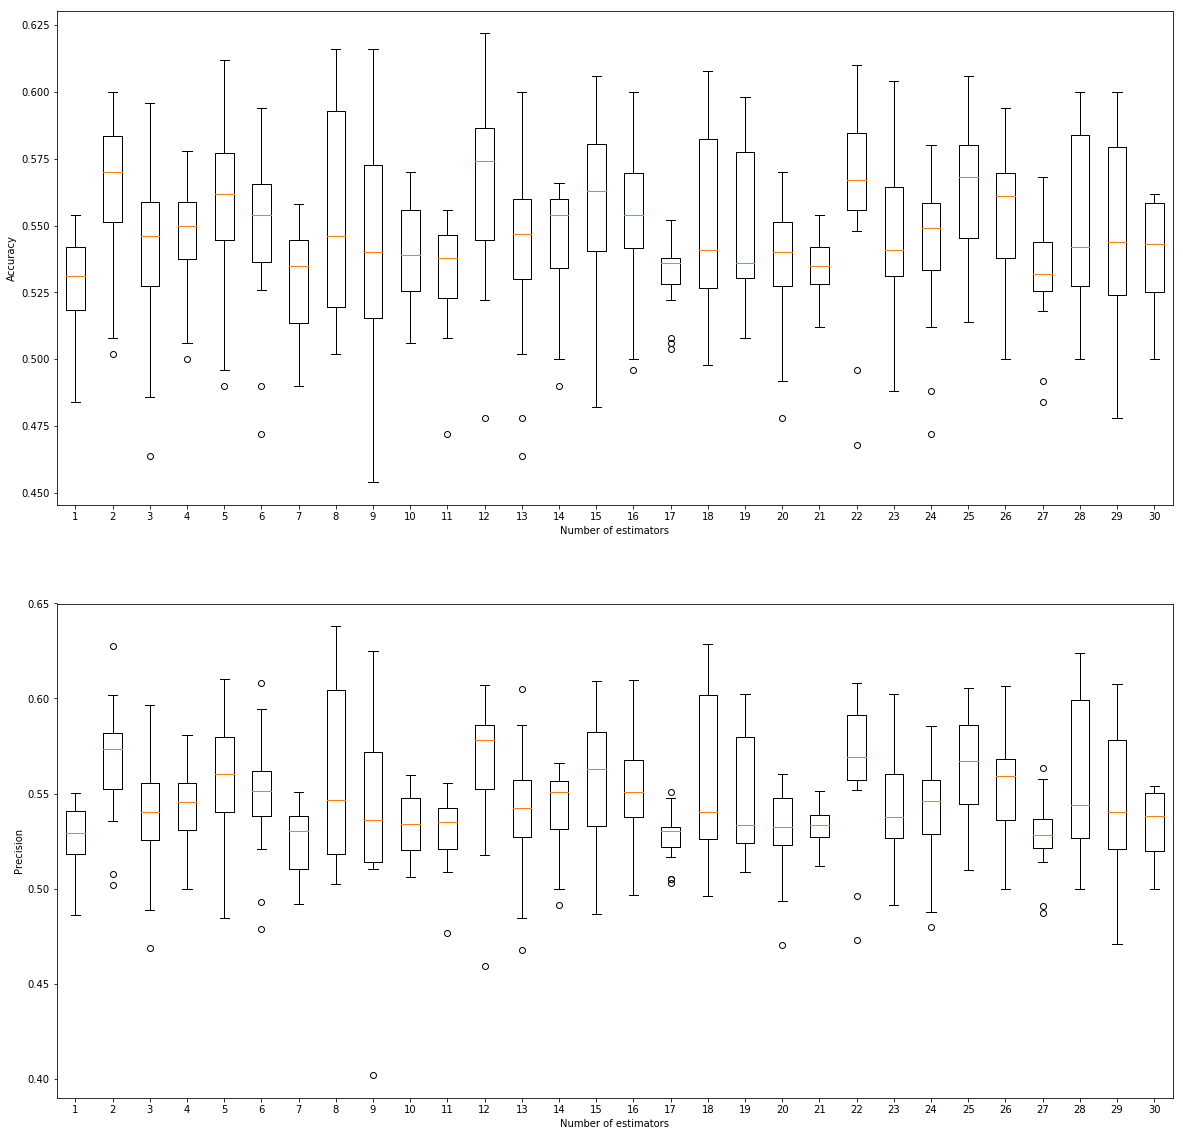

In [9]:
run = '4'
dataset_name = 'german_credit'
influence_type = 'SHAP'
n_ests = 30
params = {'learningRate':0.01,
          'weightDecay':0.00005,
          'testSize':0.2,
          'nEpochs':80,
          'randomState':rnds[0]}
tr_ac_est,te_ac_est,ac_est,ps_est,rs_est,fs_est = [],[],[],[],[],[]

for n_est in tqdm_notebook(range(1,n_ests+1),desc="Estimators:"):
    
    data,metrics = read_file(run,dataset_name,influence_type,n_est)
    tar_val,tar_lab,ref_val,ref_lab,_ = data
    tr_ac,te_ac,_,_,_,_,_,_,_,_ = metrics
    
    attack_obj = deep_attack(lr=params['learningRate'],
                             weight_decay=params['weightDecay'],
                             test_size=params['testSize'],
                             n_epochs=params['nEpochs'],
                             rs=params['randomState'])
    attack_obj.fit(ref_val,ref_lab)
    attack_obj.predict(tar_val,tar_lab)
    _,_,_,_,_,_,_,_,target_accuracy,target_precision,target_recall,target_f1 = attack_obj.get_results()
    
    tr_ac_est.append(tr_ac)
    te_ac_est.append(te_ac)
    ac_est.append(target_accuracy)
    ps_est.append(target_precision)
    rs_est.append(target_recall)
    fs_est.append(target_f1)
    
ac_est = np.array(ac_est)
ps_est = np.array(ps_est)
rs_est = np.array(rs_est)
fs_est = np.array(fs_est)

print("########## {c}-{d} ##########".format(c=dataset_name,d=influence_type))

gen_err = np.subtract(np.mean(tr_ac_est,axis=1),np.mean(te_ac_est,axis=1))
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Metric')
ax.plot(np.arange(1,n_ests+1),np.mean(ac_est,axis=1),label='Attack accuracy')
ax.plot(np.arange(1,n_ests+1),np.mean(ps_est,axis=1),label='Attack precision')
ax.plot(np.arange(1,n_ests+1),np.mean(rs_est,axis=1),label='Attack recall')
ax.plot(np.arange(1,n_ests+1),np.mean(fs_est,axis=1),label='Attack f1')
ax.tick_params(axis='y')

axtwin = ax.twinx()  # instantiate a second axes that shares the same x-axis
axtwin.set_ylabel('Generalization Error',color='magenta')  # we already handled the x-label with ax1
axtwin.plot(np.arange(1,n_ests+1),gen_err,'--',label='Generalization Error',color='magenta')
axtwin.tick_params(axis='y',labelcolor='magenta')
# ax.set_ylim(0.4,0.7)

if dataset_name == 'german_credit':
    axtwin.set_ylim(0.07,0.14)
elif dataset_name == 'bcw':
    axtwin.set_ylim(0.03,0.07)
elif dataset_name == 'pima_diabetes':
    axtwin.set_ylim(0.06,0.11)


ax.legend(loc='upper left')
axtwin.legend(loc='upper right')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# # BOX PLOTS

f,ax=plt.subplots(2,1,figsize=(20,20))
f1=ax[0].boxplot(ac_est.reshape(20,n_ests))
f2=ax[1].boxplot(ps_est.reshape(20,n_ests))
ax[0].set_xlabel('Number of estimators')
ax[0].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of estimators')
ax[1].set_ylabel('Precision')

plt.show()


########## pima_diabetes-SHAP ##########


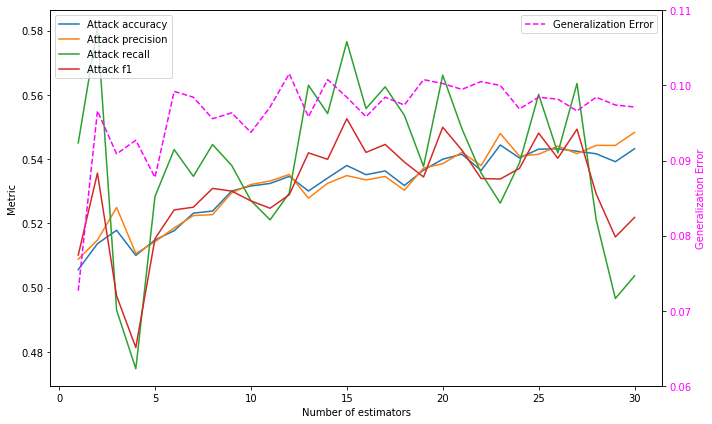

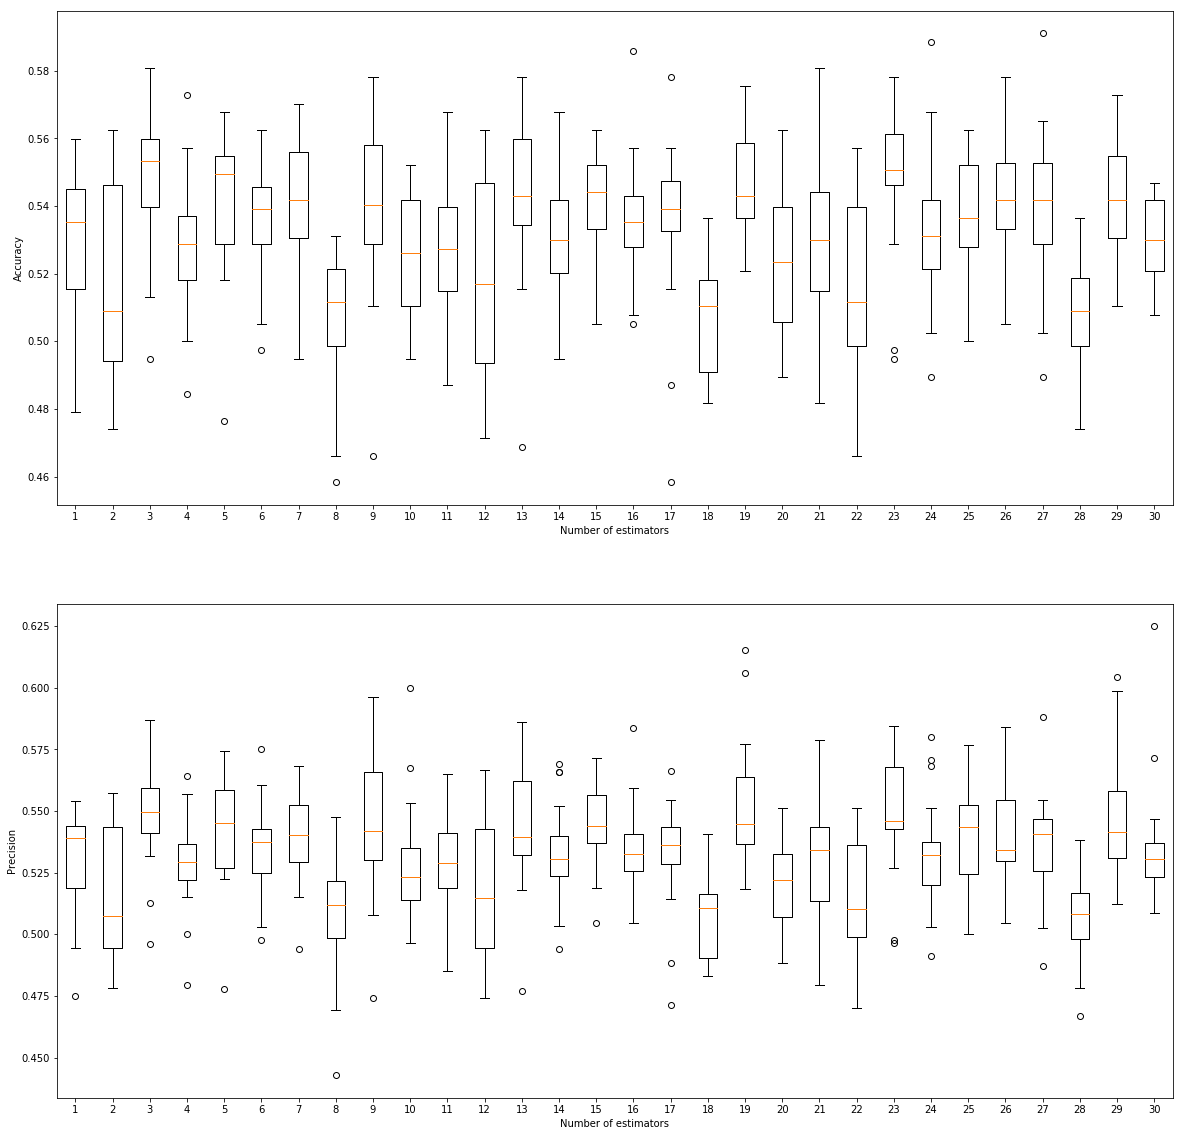

In [14]:
run = '4'
dataset_name = 'pima_diabetes'
influence_type = 'SHAP'
n_ests = 30
params = {'learningRate':0.01,
          'weightDecay':0.00005,
          'testSize':0.2,
          'nEpochs':80,
          'randomState':rnds[0]}
tr_ac_est,te_ac_est,ac_est,ps_est,rs_est,fs_est = [],[],[],[],[],[]

for n_est in tqdm_notebook(range(1,n_ests+1),desc="Estimators:"):
    
    data,metrics = read_file(run,dataset_name,influence_type,n_est)
    tar_val,tar_lab,ref_val,ref_lab,_ = data
    tr_ac,te_ac,_,_,_,_,_,_,_,_ = metrics
    
    attack_obj = deep_attack(lr=params['learningRate'],
                             weight_decay=params['weightDecay'],
                             test_size=params['testSize'],
                             n_epochs=params['nEpochs'],
                             rs=params['randomState'])
    attack_obj.fit(ref_val,ref_lab)
    attack_obj.predict(tar_val,tar_lab)
    _,_,_,_,_,_,_,_,target_accuracy,target_precision,target_recall,target_f1 = attack_obj.get_results()
    
    tr_ac_est.append(tr_ac)
    te_ac_est.append(te_ac)
    ac_est.append(target_accuracy)
    ps_est.append(target_precision)
    rs_est.append(target_recall)
    fs_est.append(target_f1)
    
ac_est = np.array(ac_est)
ps_est = np.array(ps_est)
rs_est = np.array(rs_est)
fs_est = np.array(fs_est)

print("########## {c}-{d} ##########".format(c=dataset_name,d=influence_type))

gen_err = np.subtract(np.mean(tr_ac_est,axis=1),np.mean(te_ac_est,axis=1))
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Metric')
ax.plot(np.arange(1,n_ests+1),np.mean(ac_est,axis=1),label='Attack accuracy')
ax.plot(np.arange(1,n_ests+1),np.mean(ps_est,axis=1),label='Attack precision')
ax.plot(np.arange(1,n_ests+1),np.mean(rs_est,axis=1),label='Attack recall')
ax.plot(np.arange(1,n_ests+1),np.mean(fs_est,axis=1),label='Attack f1')
ax.tick_params(axis='y')

axtwin = ax.twinx()  # instantiate a second axes that shares the same x-axis
axtwin.set_ylabel('Generalization Error',color='magenta')  # we already handled the x-label with ax1
axtwin.plot(np.arange(1,n_ests+1),gen_err,'--',label='Generalization Error',color='magenta')
axtwin.tick_params(axis='y',labelcolor='magenta')
# ax.set_ylim(0.4,0.7)

if dataset_name == 'german_credit':
    axtwin.set_ylim(0.07,0.14)
elif dataset_name == 'bcw':
    axtwin.set_ylim(0.03,0.07)
elif dataset_name == 'pima_diabetes':
    axtwin.set_ylim(0.06,0.11)


ax.legend(loc='upper left')
axtwin.legend(loc='upper right')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# # BOX PLOTS

f,ax=plt.subplots(2,1,figsize=(20,20))
f1=ax[0].boxplot(ac_est.reshape(20,n_ests))
f2=ax[1].boxplot(ps_est.reshape(20,n_ests))
ax[0].set_xlabel('Number of estimators')
ax[0].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of estimators')
ax[1].set_ylabel('Precision')

plt.show()


########## german_credit-SHAP ##########


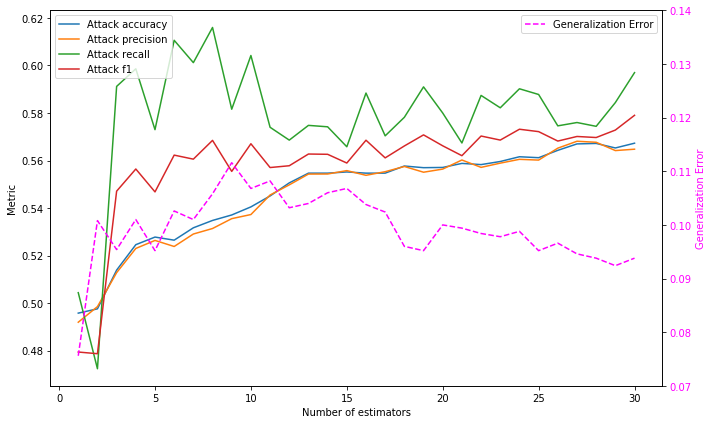

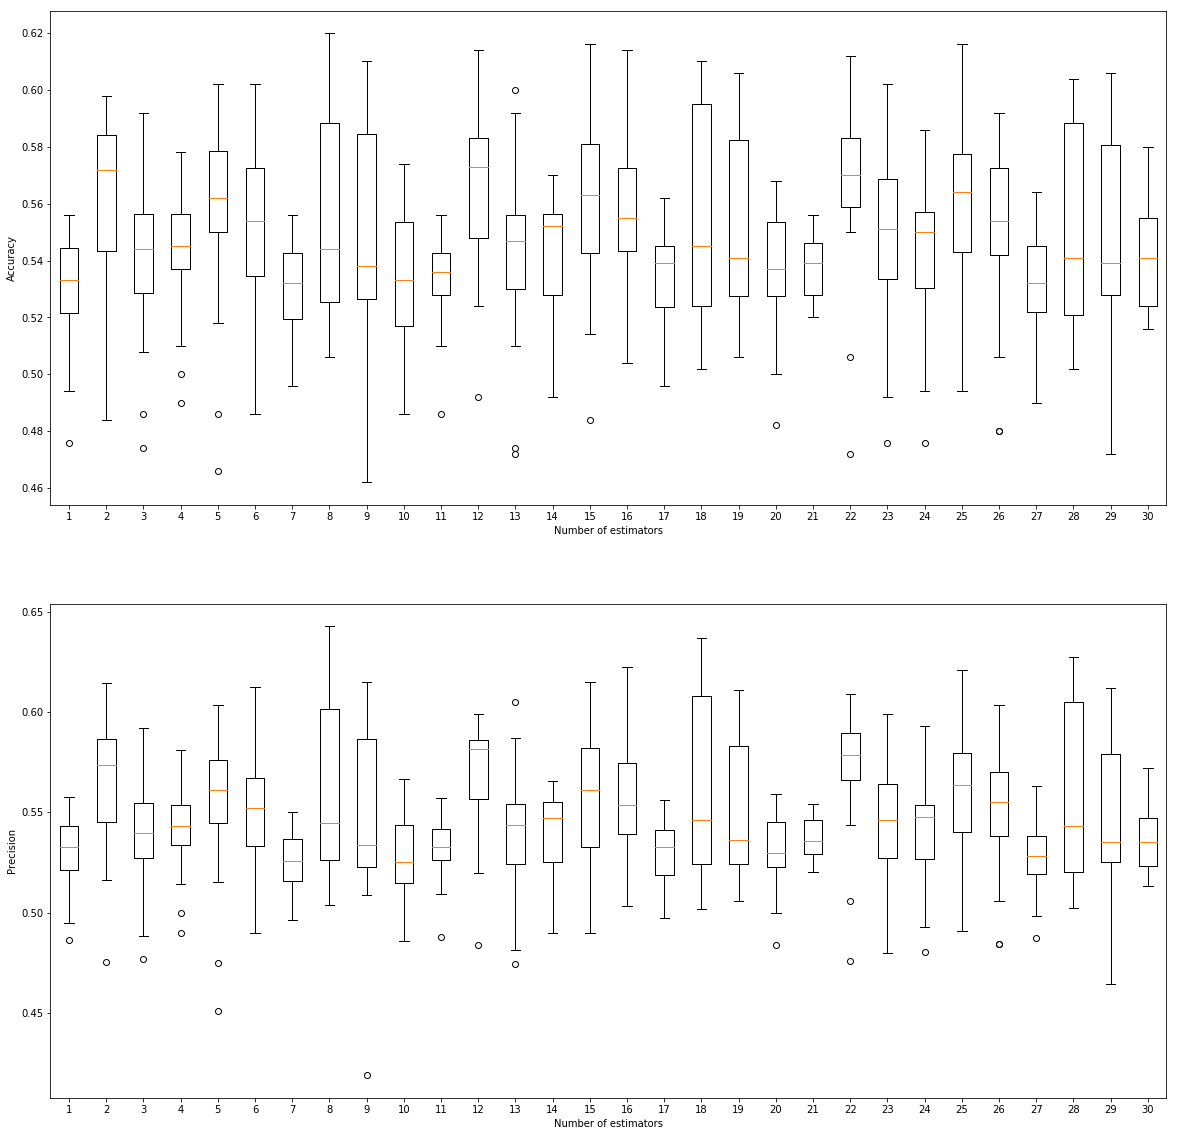

In [15]:
run = '4'
dataset_name = 'german_credit'
influence_type = 'SHAP'
n_ests = 30
params = {'learningRate':0.01,
          'weightDecay':0.00005,
          'testSize':0.2,
          'nEpochs':80,
          'randomState':rnds[0]}
tr_ac_est,te_ac_est,ac_est,ps_est,rs_est,fs_est = [],[],[],[],[],[]

for n_est in tqdm_notebook(range(1,n_ests+1),desc="Estimators:"):
    
    data,metrics = read_file(run,dataset_name,influence_type,n_est)
    tar_val,tar_lab,ref_val,ref_lab,_ = data
    tr_ac,te_ac,_,_,_,_,_,_,_,_ = metrics
    
    attack_obj = deep_attack(lr=params['learningRate'],
                             weight_decay=params['weightDecay'],
                             test_size=params['testSize'],
                             n_epochs=params['nEpochs'],
                             rs=params['randomState'])
    attack_obj.fit(ref_val,ref_lab)
    attack_obj.predict(tar_val,tar_lab)
    _,_,_,_,_,_,_,_,target_accuracy,target_precision,target_recall,target_f1 = attack_obj.get_results()
    
    tr_ac_est.append(tr_ac)
    te_ac_est.append(te_ac)
    ac_est.append(target_accuracy)
    ps_est.append(target_precision)
    rs_est.append(target_recall)
    fs_est.append(target_f1)
    
ac_est = np.array(ac_est)
ps_est = np.array(ps_est)
rs_est = np.array(rs_est)
fs_est = np.array(fs_est)

print("########## {c}-{d} ##########".format(c=dataset_name,d=influence_type))

gen_err = np.subtract(np.mean(tr_ac_est,axis=1),np.mean(te_ac_est,axis=1))
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Metric')
ax.plot(np.arange(1,n_ests+1),np.mean(ac_est,axis=1),label='Attack accuracy')
ax.plot(np.arange(1,n_ests+1),np.mean(ps_est,axis=1),label='Attack precision')
ax.plot(np.arange(1,n_ests+1),np.mean(rs_est,axis=1),label='Attack recall')
ax.plot(np.arange(1,n_ests+1),np.mean(fs_est,axis=1),label='Attack f1')
ax.tick_params(axis='y')

axtwin = ax.twinx()  # instantiate a second axes that shares the same x-axis
axtwin.set_ylabel('Generalization Error',color='magenta')  # we already handled the x-label with ax1
axtwin.plot(np.arange(1,n_ests+1),gen_err,'--',label='Generalization Error',color='magenta')
axtwin.tick_params(axis='y',labelcolor='magenta')
# ax.set_ylim(0.4,0.7)

if dataset_name == 'german_credit':
    axtwin.set_ylim(0.07,0.14)
elif dataset_name == 'bcw':
    axtwin.set_ylim(0.03,0.07)
elif dataset_name == 'pima_diabetes':
    axtwin.set_ylim(0.06,0.11)


ax.legend(loc='upper left')
axtwin.legend(loc='upper right')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# # BOX PLOTS

f,ax=plt.subplots(2,1,figsize=(20,20))
f1=ax[0].boxplot(ac_est.reshape(20,n_ests))
f2=ax[1].boxplot(ps_est.reshape(20,n_ests))
ax[0].set_xlabel('Number of estimators')
ax[0].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of estimators')
ax[1].set_ylabel('Precision')

plt.show()